# Лабораторная работа №5

## 5.1. Немарковская динамика

Рассматриваем состояние 6 кубитов.

In [1]:
import numpy as np
import copy

In [2]:
n = 6

Зафиксируем random.seed для воспроизводимости экспериментов.

In [3]:
np.random.seed(2)

Генерируем случайным образом чистое состояние первого кубита.

In [4]:
phys_ind = [2]
state = np.random.randn(*phys_ind) + 1j * np.random.randn(*phys_ind)
psi_first_qubit = state / np.sqrt(np.sum(state * np.conjugate(state)))
psi_first_qubit = np.reshape(psi_first_qubit, tuple(phys_ind + [1]))

Генерируем случайным образом чистое состояние остальных 5 кубитов.

In [5]:
phys_ind = [2] * (n - 1)
state = np.random.randn(*phys_ind) + 1j * np.random.randn(*phys_ind)
psi_other_qubit = state / np.sqrt(np.sum(state * np.conjugate(state)))
psi_other_qubit = np.reshape(psi_other_qubit, tuple([1] + phys_ind))

Находим общее состояние 6 кубитов как тензорное произведение состояния первого кубита на состояние остальных 5 кубитов (так как по условию задания первый кубит должен быть не запутан с остальными).

In [6]:
psi = np.tensordot(psi_first_qubit, psi_other_qubit, axes=([1], [0])).reshape(-1)

Напишем функцию, которая зная чистое состояние всей системы в формате $\psi_{i_1 ... i_n}$ будет выдавать нам матрицу плотности первого кубита. Для этого сначала представляем чистое состояние всей системы в виде матрицы $\psi_{i_1 i_2}$, где $i_1$ - индекс первого кубита, а $i_2$ - индекс остальных 5 кубитов. Затем находим тензор плотности всей системы $\rho_{i_1 i_2 j_1 j_2} = \psi_{i_1 i_2} \psi_{j_1 j_2}^{*}$. Затем вычисляем частичный след по всем кубитам, кроме первого, то есть по индексам $i_2$ и $j_2$.

In [7]:
def get_density_matrix_first_qubit(tensor_psi, n):
    psi = np.reshape(tensor_psi, tuple([2] + [2 ** (n - 1)] + [1]))
    psi_conjugate = np.reshape(tensor_psi, tuple([1] + [2] + [2 ** (n - 1)])).conjugate()
    rho = np.tensordot(psi, psi_conjugate, axes=([2], [0]))
    rho_first_qubit = np.trace(rho, axis1=1, axis2=3)
    return rho_first_qubit

Напишем функцию, которая будет определять чистоту состояния первого кубита.

In [8]:
def get_purity_first_qubit(rho_first_qubit):
    return np.trace(rho_first_qubit @ rho_first_qubit).real

Создадим класс $\operatorname{Ham}()$, который будет конструировать Гамильтониан $\sum_{k = 1}^n X_k + \sum_{k = 1}^n Z_k Z_{n - k + 1}$ в виде матрицы размером $2^n$ на $2^n$.

In [9]:
class Ham(object):
    def __init__(self, n):
        self.N = n
        self.identity = np.array([[1, 0],
                                  [0, 1]], dtype=complex)
        self.sigma_x = np.array([[0, 1],
                                 [1, 0]], dtype=complex)
        self.sigma_y = np.array([[0, -1j],
                                 [1j, 0]], dtype=complex)
        self.sigma_z = np.array([[1, 0],
                                 [0, -1]], dtype=complex)
        self.ham = self.evaluate_ham()
    
    def get_one_pauli(self, pauli_k, k):
        ham = np.array([[1]], dtype=complex)
        for i in range(self.N):
            if i == k:
                ham = np.kron(ham, pauli_k)
            else:
                ham = np.kron(ham, self.identity)
        return ham
    
    def get_two_pauli(self, pauli_k, pauli_l, k, l):
        ham = np.array([[1]], dtype=complex)
        if k == l:
            for i in range(self.N):
                if i == k:
                    ham = np.kron(ham, pauli_k @ pauli_l)
                else:
                    ham = np.kron(ham, self.identity)
        else:
            for i in range(self.N):
                if i == k:
                    ham = np.kron(ham, pauli_k)
                elif i == l:
                    ham = np.kron(ham, pauli_l)
                else:
                    ham = np.kron(ham, self.identity)
        return ham
        
    def evaluate_ham(self):
        ham = np.zeros((2 ** self.N, 2 ** self.N), dtype=complex)
        for i in range(0, self.N, 1):
            ham += self.get_one_pauli(self.sigma_x, i)
        for i in range(0, self.N, 1):
            ham += self.get_two_pauli(self.sigma_z, self.sigma_z, i, self.N - i - 1)
        return ham
    
    def get_ham(self):
        return self.ham

In [10]:
from scipy.linalg import expm

Создадим класс $\operatorname{Evolution}()$, который будет рассчитывать эволюцию квантового состояния под действием Гамильтониана согласно решению уравнению Шрёдингера $\dfrac{\partial{\psi}}{\partial t} = -i H(t) \psi$ с помощью матричной экспоненты $\psi(t) = U(t) \psi(0)$, где $U(t) = \exp(-i H t)$.

In [11]:
class Evolution(object):
    def __init__(self):
        self.psi = None
        self.ham = None
        self.list_psi = None
        self.final_psi = None
    
    def set_psi(self, psi):
        self.psi = copy.copy(psi)
    
    def set_ham(self, ham):
        self.ham = ham
    
    def evolution_EXPM(self, time_evolution, dt):
        self.list_psi = [copy.copy(self.psi)]
        t = 0
        while (t < time_evolution):
            U = expm(-1j * self.ham.get_ham() * t)
            self.list_psi.append(copy.copy(np.dot(U, self.psi)))
            t += dt
        self.final_psi = self.list_psi[-1]

    def get_psi(self):
        return self.psi
    
    def get_list_psi(self):
        return self.list_psi
    
    def get_final_psi(self):
        return self.final_psi

Напишем функцию, которая будет вычислять общее состояние системы и чистоту состояния первого кубита в определённые момоенты времени с шагом $dt$.

In [12]:
def get_purity_evolution(time_evolution, dt, ham, psi_0, n):
    t = 0
    timeslots = [t]
    while (t < time_evolution):
        timeslots.append(t)
        t += dt
    timeslots = np.array(timeslots)
    evolution = Evolution()
    evolution.set_psi(psi_0)
    evolution.set_ham(ham)
    evolution.evolution_EXPM(time_evolution, dt)
    list_psi_EXPM = evolution.list_psi
    list_purity_EXPM = np.array([get_purity_first_qubit(get_density_matrix_first_qubit(psi_EXPM, n)) for psi_EXPM in list_psi_EXPM])
    return timeslots, list_psi_EXPM, list_purity_EXPM

Задаём время эволюции и Гамильтониан.

In [13]:
time_evolution = 1.0
ham = Ham(n)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

Определяем чистое состояние всей системы из 6 кубитов и чистоту состояния первого кубита в определённые моменты времени.

In [15]:
timeslots, list_psi_EXPM, list_purity_EXPM = get_purity_evolution(time_evolution, 0.01, ham, psi, n)

Создаём класс $\operatorname{State}()$ для того, чтобы действовать на состояние всей системы однокубитными и двухкубитными гейтами.

In [16]:
class State(object):
    def __init__(self):
        self.N = None
        self.phys_ind = []
        self.full_tensor = None

    def all_zeros_state(self, n):
        self.N = n
        self.phys_ind = []
        state_qubit = np.reshape(np.array([1, 0], dtype=complex), [1, 2, 1])
        self.full_tensor = state_qubit
        self.phys_ind.append(2)
        for i in range(1, n, 1):
            self.full_tensor = np.tensordot(self.full_tensor, state_qubit, axes=([-1], [0]))
            self.phys_ind.append(2)
        self.full_tensor = self.full_tensor.reshape(self.phys_ind)

    def return_full_tensor(self):
        return self.full_tensor

    def return_full_vector(self):
        return self.full_tensor.reshape(-1)

    def one_qubit_gate(self, u, k):
        self.full_tensor = np.tensordot(u, self.full_tensor, axes=([1], [k]))
        self.full_tensor = np.transpose(self.full_tensor, axes=tuple(list(np.arange(1, k + 1, 1)) + [0] +
                                                                     list(np.arange(k + 1, self.N, 1))))

    def two_qubit_gate(self, u, k, l):
        if l < k:
            k, l = l, k
        u = np.reshape(u, [2, 2, 2, 2])
        self.full_tensor = np.tensordot(u, self.full_tensor, axes=([2, 3], [k, l]))
        self.full_tensor = np.transpose(self.full_tensor, axes=tuple(list(np.arange(2, k + 2, 1)) + [0] +
                                                                     list(np.arange(k + 2, l + 1, 1)) + [1] +
                                                                     list(np.arange(l + 1, self.N))))

Создаём класс $\operatorname{EvolutionTrotter}()$ для расчёта динамики с использованием троттеризации с таким же Гамильтонианом $\sum_{k = 1}^n X_k + \sum_{k = 1}^n Z_k Z_{n - k + 1}$.

In [17]:
class EvolutionTrotter(object):
    def __init__(self, n_qubits):
        self.psi = None
        self.ham = None
        self.list_psi = None
        self.final_psi = None
        self.N = n_qubits
        self.identity = np.array([[1, 0],
                                  [0, 1]], dtype=complex)
        self.sigma_x = np.array([[0, 1],
                                 [1, 0]], dtype=complex)
        self.sigma_y = np.array([[0, -1j],
                                 [1j, 0]], dtype=complex)
        self.sigma_z = np.array([[1, 0],
                                 [0, -1]], dtype=complex)
    
    def set_psi(self, psi):
        self.psi = copy.copy(psi)
    
    def evolution_trotter(self, time_evolution, dt, n):
        self.list_psi = [copy.copy(self.psi)]
        t = 0
        while (t < time_evolution):
            state = State()
            state.all_zeros_state(self.N)
            state.full_tensor = np.reshape(self.psi, tuple([2] * self.N))
            for i in range(n):
                for j in range(self.N):
                    state.one_qubit_gate(expm(-1j * self.sigma_x * t / n), j)
                for j in range(self.N):
                    state.two_qubit_gate(expm(-1j * np.kron(self.sigma_z, self.sigma_z) * t / n), j, self.N - j - 1)
            self.list_psi.append(copy.copy(state.return_full_vector()))
            t += dt
        self.final_psi = self.list_psi[-1]

    def get_psi(self):
        return self.psi
    
    def get_list_psi(self):
        return self.list_psi
    
    def get_final_psi(self):
        return self.final_psi

Напишем функцию, которая будет вычислять общее состояние системы и чистоту состояния первого кубита в определённые момоенты времени с шагом $dt$ с использованием разложения Троттера.

In [18]:
def get_purity_evolution_trotter(time_evolution, dt, psi_0, n_qubits, n):
    t = 0
    timeslots = [t]
    while (t < time_evolution):
        timeslots.append(t)
        t += dt
    timeslots = np.array(timeslots)
    evolution = EvolutionTrotter(n_qubits)
    evolution.set_psi(psi_0)
    evolution.evolution_trotter(time_evolution, dt, n)
    list_psi_Trotter = evolution.list_psi
    list_purity_Trotter = np.array([get_purity_first_qubit(get_density_matrix_first_qubit(psi_Trotter, n_qubits)) for psi_Trotter in list_psi_Trotter])
    return timeslots, list_psi_Trotter, list_purity_Trotter

In [19]:
timeslots, list_psi_Trotter_2, list_purity_Trotter_2 = get_purity_evolution_trotter(time_evolution, 0.01, psi, n, 2)

In [20]:
timeslots, list_psi_Trotter_10, list_purity_Trotter_10 = get_purity_evolution_trotter(time_evolution, 0.01, psi, n, 10)

In [21]:
timeslots, list_psi_Trotter_100, list_purity_Trotter_100 = get_purity_evolution_trotter(time_evolution, 0.01, psi, n, 100)

Строим графики чистоты состояния первого кубита от времени для различного числа разбиений в разложении Троттера.

In [22]:
fig, ax = plt.subplots()
plt.plot(timeslots, list_purity_EXPM, lw=3, alpha=0.3, label='EXPM, dt = ' + str(0.01))
plt.plot(timeslots, list_purity_Trotter_2, '--', lw=3, alpha=1.0, label='Trotter, dt = ' + str(0.01) + ', n = 2')
plt.plot(timeslots, list_purity_Trotter_10, '--', lw=3, alpha=1.0, label='Trotter, dt = ' + str(0.01) + ', n = 10')
plt.plot(timeslots, list_purity_Trotter_100, '--', lw=3, alpha=1.0, label='Trotter, dt = ' + str(0.01) + ', n = 100')
ax.legend(loc='upper right')
ax.minorticks_off()
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$Tr(\rho^2)$', fontsize=15)
plt.show()

Напишем функцию, которая будет считать фиделити между точным расчётом эволюции с помощью метода матричной экспоненты и расчётом с помощью использования разложения Троттера.

In [23]:
def get_error_trotter(list_psi_EXPM, list_psi_Trotter):
    list_errors = []
    for i, psi in enumerate(list_psi_Trotter):
        list_errors.append(np.abs(np.dot(psi.conjugate(), list_psi_EXPM[i])) ** 2)
    return np.array(list_errors)

Строим графики фиделити между точным расчётом эволюции с помощью метода матричной экспоненты и расчётом с помощью использования разложения Троттера для различного числа разбиений в разложении Троттера.

In [24]:
fig, ax = plt.subplots()
plt.plot(timeslots, get_error_trotter(list_psi_EXPM, list_psi_Trotter_2), '--', lw=3, alpha=1.0, label='Trotter, dt = ' + str(0.01) + ', n = 2')
plt.plot(timeslots, get_error_trotter(list_psi_EXPM, list_psi_Trotter_10), '--', lw=3, alpha=1.0, label='Trotter, dt = ' + str(0.01) + ', n = 10')
plt.plot(timeslots, get_error_trotter(list_psi_EXPM, list_psi_Trotter_100), '--', lw=3, alpha=1.0, label='Trotter, dt = ' + str(0.01) + ', n = 100')
ax.legend(loc='lower left')
ax.minorticks_off()
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$|\langle\psi | \psi_{\operatorname{Trotter}} \rangle|^2$', fontsize=15)
plt.show()

## 5.2. Эффект спинового эха

Рассматриваем состояние 5 кубитов.

In [25]:
n = 5

Зафиксируем random.seed для воспроизводимости экспериментов.

In [26]:
np.random.seed(2)

Генерируем случайным образом чистое состояние первого кубита.

In [27]:
phys_ind = [2]
state = np.random.randn(*phys_ind) + 1j * np.random.randn(*phys_ind)
psi_first_qubit = state / np.sqrt(np.sum(state * np.conjugate(state)))
psi_first_qubit = np.reshape(psi_first_qubit, tuple(phys_ind + [1]))

Генерируем случайным образом чистое состояние остальных 4 кубитов.

In [28]:
phys_ind = [2] * (n - 1)
state = np.random.randn(*phys_ind) + 1j * np.random.randn(*phys_ind)
psi_other_qubit = state / np.sqrt(np.sum(state * np.conjugate(state)))
psi_other_qubit = np.reshape(psi_other_qubit, tuple([1] + phys_ind))

Находим общее состояние 6 кубитов как тензорное произведение состояния первого кубита на состояние остальных 5 кубитов (так как по условию задания первый кубит должен быть не запутан с остальными).

In [29]:
psi = np.tensordot(psi_first_qubit, psi_other_qubit, axes=([1], [0])).reshape(-1)

Создадим класс $\operatorname{HamEcho}()$, который будет конструировать Гамильтониан $1.5 \sum_{k = 1}^n X_k + \sum_{k = 2}^n 2^{k - 1} Z_1 Z_k$ в виде матрицы размером $2^n$ на $2^n$.

In [30]:
class HamEcho(Ham):
    def __init__(self, n):
        super().__init__(n)
        
    def evaluate_ham(self):
        ham = np.eye(2 ** self.N, dtype=complex)
        for i in range(0, self.N, 1):
            ham += 1.5 * self.get_one_pauli(self.sigma_z, i)
        for i in range(1, self.N, 1):
            ham += (2 ** i) * self.get_two_pauli(self.sigma_z, self.sigma_z, 0, i)
        return ham

Напишем функцию, которая будет вычислять общее состояние системы, недиагональный элемент матрицы плотности первого кубита и  чистоту состояния первого кубита в определённые момоенты времени с шагом $dt$ с использованием вычисления матричной экспоненты.

In [31]:
def get_purity_and_non_diagonal_evolution(time_evolution, dt, ham, psi_0, n):
    t = 0
    timeslots = [t]
    while (t < time_evolution):
        timeslots.append(t)
        t += dt
    timeslots = np.array(timeslots)
    evolution = Evolution()
    evolution.set_psi(psi_0)
    evolution.set_ham(ham)
    evolution.evolution_EXPM(time_evolution, dt)
    list_psi_EXPM = evolution.list_psi
    list_rho_first_qubit_EXPM = np.array([np.abs(get_density_matrix_first_qubit(psi_EXPM, n)[0, 1]) for psi_EXPM in list_psi_EXPM])
    list_purity_EXPM = np.array([get_purity_first_qubit(get_density_matrix_first_qubit(psi_EXPM, n)) for psi_EXPM in list_psi_EXPM])
    return timeslots, list_psi_EXPM, list_rho_first_qubit_EXPM, list_purity_EXPM

Задаём время эволюции и Гамильтониан.

In [32]:
time_evolution = 1.0
ham = HamEcho(n)

In [33]:
timeslots, list_psi_EXPM, list_rho_first_qubit_EXPM, list_purity_EXPM = get_purity_and_non_diagonal_evolution(time_evolution, 0.01, ham, psi, n)

Построим график зависимости модуля недиагонального элемента матрицы плотности первого кубита от времени на временном отрезке $[0, 1]$.

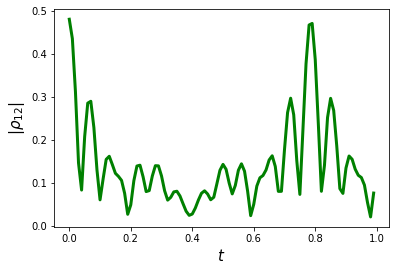

In [34]:
fig, ax = plt.subplots()
plt.plot(timeslots, list_rho_first_qubit_EXPM, lw=3, alpha=1.0, color='green')
ax.minorticks_off()
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$|\rho_{12}|$', fontsize=15)
plt.show()

Построим график зависимости чистоты состояния первого кубита от времени на временном отрезке $[0, 1]$.

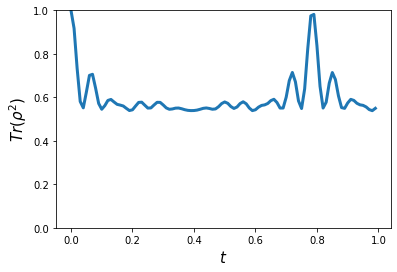

In [35]:
fig, ax = plt.subplots()
plt.plot(timeslots, list_purity_EXPM, lw=3)
ax.minorticks_off()
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$Tr(\rho^2)$', fontsize=15)
plt.ylim(0, 1)
plt.show()

In [36]:
timeslots, list_psi_EXPM, list_rho_first_qubit_EXPM, list_purity_EXPM = get_purity_and_non_diagonal_evolution(0.1, 0.0001, ham, psi, n)

Вычисляем время фазовой релаксации $T_2$.

In [37]:
T2 = 0
fl = True
rho_00 = list_rho_first_qubit_EXPM[0]
rho_00_target = rho_00 / np.e
for i, time in enumerate(timeslots):
    if fl:
        if list_rho_first_qubit_EXPM[i] < rho_00_target:
            T2 = time
            fl = False

In [38]:
print(T2)

0.028199999999999885


Повторно проведём симуляцию эволюции квантового состояния под действием выбранного гамильтониана на временном отрезке $[0, 2T_2]$. В момент времени $T_2$ подействуем оператором $X_1$ на первый кубит.

In [39]:
timeslots_0_T2, list_psi_EXPM_0_T2, list_rho_first_qubit_EXPM_0_T2, list_purity_EXPM_0_T2 = get_purity_and_non_diagonal_evolution(T2, 0.0001, ham, psi, n)

In [40]:
state = State()
state.all_zeros_state(n)
state.full_tensor = np.reshape(list_psi_EXPM_0_T2[-1], tuple([2] * n))
sigma_x = np.array([[0, 1], 
                    [1, 0]], dtype=complex)
state.one_qubit_gate(sigma_x, 0)
psi_T2 = state.return_full_vector()

In [41]:
timeslots_T2_2T2, list_psi_EXPM_T2_2T2, list_rho_first_qubit_EXPM_T2_2T2, list_purity_EXPM_T2_2T2 = get_purity_and_non_diagonal_evolution(T2, 0.0001, ham, psi_T2, n)

In [42]:
timeslots_0_2T2 = np.array(list(timeslots_0_T2) + list(timeslots_T2_2T2 + T2))
list_psi_EXPM_0_2T2 = np.array(list(list_psi_EXPM_0_T2) + list(list_psi_EXPM_T2_2T2))
list_rho_first_qubit_EXPM_0_2T2 = np.array(list(list_rho_first_qubit_EXPM_0_T2) + list(list_rho_first_qubit_EXPM_T2_2T2))
list_purity_EXPM_0_2T2 = np.array(list(list_purity_EXPM_0_T2) + list(list_purity_EXPM_T2_2T2))

Построим график зависимости модуля недиагонального элемент аматрицы плотности первого кубита от времени в этом случае.

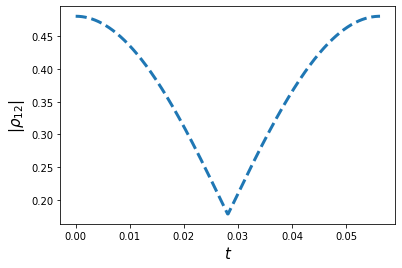

In [43]:
fig, ax = plt.subplots()
plt.plot(timeslots_0_2T2, list_rho_first_qubit_EXPM_0_2T2, '--', lw=3, alpha=1.0)
ax.minorticks_off()
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$|\rho_{12}|$', fontsize=15)
plt.show()

Построим график зависимости чистоты состояния первого кубита от времени на временном отрезке $[0, 2T_2]$ в этом случае.

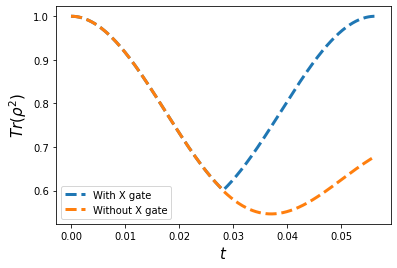

In [44]:
fig, ax = plt.subplots()
plt.plot(timeslots_0_2T2, list_purity_EXPM_0_2T2, '--', lw=3, alpha=1.0, label='With X gate')
plt.plot(timeslots_0_2T2, list_purity_EXPM[0:len(timeslots_0_2T2)], '--', lw=3, alpha=1.0, label='Without X gate')
ax.legend(loc='lower left')
ax.minorticks_off()
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$Tr(\rho^2)$', fontsize=15)
plt.show()

Вычислим значения чистоты состояния первого кубита в моменты времени $t = 0$ и $t = 2T_2$.

In [45]:
print(list_purity_EXPM_0_2T2[0], list_purity_EXPM_0_2T2[-1])

0.9999999999999991 0.9999999999999993


Видно, что значения чистоты состояния первого кубита в моменты времени $t = 0$ и $t = 2T_2$ с хорошей точностью совпадают и равны 1.